# Analysis of IMDB Data

We will analyze a subset of IMDB's actors, genres, movie actors, and movie ratings data. This dataset comes to us from Kaggle (https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset) although we have taken steps to pull this data into a publis s3 bucket: 

* s3://cis9760-lecture9-movieanalysis/name.basics.tsv ---> (actors)
* s3://cis9760-lecture9-movieanalysis/title.basics.tsv ---> (genres)
* s3://cis9760-lecture9-movieanalysis/title.principals.tsv ---> (movie actors)
* s3://cis9760-lecture9-movieanalysis/title.ratings.tsv ---> (movie ratings)

# Content

**<br />name.basics.tsv.gz – Contains the following information for names:**
<br />nconst (string) - alphanumeric unique identifier of the name/person.
<br />primaryName (string)– name by which the person is most often credited.
<br />birthYear – in YYYY format.
<br />deathYear – in YYYY format if applicable, else .
<br />primaryProfession (array of strings)– the top-3 professions of the person.
<br />knownForTitles (array of tconsts) – titles the person is known for.
<br/><br/>
**<br />title.basics.tsv.gz - Contains the following information for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc).
<br />primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release.
<br />originalTitle (string) - original title, in the original language.
<br />isAdult (boolean) - 0: non-adult title; 1: adult title.
<br />startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year.
<br />endYear (YYYY) – TV Series end year. for all other title types.
<br />runtimeMinutes – primary runtime of the title, in minutes.
<br />genres (string array) – includes up to three genres associated with the title.
<br/><br/>
**<br />title.principals.tsv – Contains the principal cast/crew for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />ordering (integer) – a number to uniquely identify rows for a given titleId.
<br />nconst (string) - alphanumeric unique identifier of the name/person.
<br />category (string) - the category of job that person was in.
<br />job (string) - the specific job title if applicable, else.
<br />characters (string) - the name of the character played if applicable, else.
<br/><br/>
**<br />title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />averageRating – weighted average of all the individual user ratings.
<br />numVotes - number of votes the title has received.

# PART 1 - Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install pandas and matplotlib

Let's install the necessary packages here

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1669695307234_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6c/10/a7d0fa5baea8fe7b50f448ab742f26f52b80bfca85ac2be9d35cdd9a3246/pyparsing-3.0.9-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ab/8f/8dbe2d4efc4c0b08ec67d6efb7cc31fbfd688c80afad85f65980633b0d37/kiwisolver-1.4.4-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_

Now, import the installed packages from the previous block below.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql.functions import split, col, explode, countDistinct, mean, count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading Data

Load all data from S3 into a Spark dataframe object 

In [3]:
# The data comes from https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset
actors = spark.read.csv('s3://cis9760-lecture9-movieanalysis/name.basics.tsv', sep=r'\t', header=True)
genres = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.basics.tsv', sep=r'\t', header=True)
movie_actors = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.principals.tsv', sep=r'\t', header=True)
movie_ratings = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.ratings.tsv', sep=r'\t', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Actors

Display the schema below:

In [5]:
actors.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)

Display the first 5 rows with the following columns:

* `primaryName`
* `birthYear`
* `deathYear`
* `knownForTitles`

In [6]:
actors.select("primaryName", "birthYear", "deathYear", "knownForTitles").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------+---------+--------------------+
|    primaryName|birthYear|deathYear|      knownForTitles|
+---------------+---------+---------+--------------------+
|   Fred Astaire|     1899|     1987|tt0050419,tt00531...|
|  Lauren Bacall|     1924|     2014|tt0071877,tt01170...|
|Brigitte Bardot|     1934|       \N|tt0054452,tt00491...|
|   John Belushi|     1949|     1982|tt0077975,tt00725...|
| Ingmar Bergman|     1918|     2007|tt0069467,tt00509...|
+---------------+---------+---------+--------------------+
only showing top 5 rows

## Genres

Display the first 10 rows with the following columns:
    
* `titleType`
* `primaryTitle`
* `genres`

In [7]:
genres.select("titleType", "primaryTitle", "genres").show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+--------------------+
|titleType|        primaryTitle|              genres|
+---------+--------------------+--------------------+
|    short|          Carmencita|   Documentary,Short|
|    short|Le clown et ses c...|     Animation,Short|
|    short|      Pauvre Pierrot|Animation,Comedy,...|
|    short|         Un bon bock|     Animation,Short|
|    short|    Blacksmith Scene|        Comedy,Short|
|    short|   Chinese Opium Den|               Short|
|    short|Corbett and Court...|         Short,Sport|
|    short|Edison Kinetoscop...|   Documentary,Short|
|    movie|          Miss Jerry|             Romance|
|    short| Exiting the Factory|   Documentary,Short|
+---------+--------------------+--------------------+
only showing top 10 rows

Display the unique categories below:

In [8]:
genres.select("titleType").distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|       movie|
|   videoGame|
|   tvSpecial|
|       video|
|     tvMovie|
|   tvEpisode|
|     tvShort|
|       short|
+------------+

Display the schema below:

In [9]:
genres.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

## Movie Actors

Display the schema below:

In [10]:
movie_actors.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)

Display the first 10 rows below

In [11]:
movie_actors.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
|tt0000003|       1|nm0721526|       director|                  \N|         \N|
|tt0000003|       2|nm5442194|       producer|            producer|         \N|
|tt0000003|       3|nm1335271|       composer|                  \N|         \N|
|tt0000003|       4|nm5442200|         editor|                  \N|         \N|
|tt0000004|       1|nm0721526|       dir

## Movie Ratings

Display the schema below:

In [12]:
movie_ratings.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)

Display the first 10 rows in a descending order by the number of votes

In [13]:
movie_ratings.select("tconst", "averageRating", "numVotes").sort(col("numVotes").desc()).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt7430722|          6.8|    9999|
|tt4445154|          8.1|    9997|
|tt2229907|          6.3|    9996|
|tt0294097|          8.0|    9994|
|tt0264734|          6.5|    9993|
|tt2032572|          5.2|    9991|
|tt8860450|          6.3|    9991|
|tt3244036|          8.3|     999|
|tt1739480|          6.9|     999|
|tt1859607|          5.3|     999|
+---------+-------------+--------+
only showing top 10 rows

# Overview of Data

Display the number of rows and columns in each dataFrame object.

In [14]:
print(f'Number of columns in Actors table: {len(actors.dtypes)}')
print(f'Number of rows in Actors table: {actors.count()}\n')

print(f'Number of columns in Genres table: {len(genres.dtypes)}')
print(f'Number of rows in Genres table: {genres.count()}\n')

print(f'Number of columns in Movie Actors table: {len(movie_actors.dtypes)}')
print(f'Number of rows in Movie Actors table: {movie_actors.count()}\n')

print(f'Number of columns in Movie Ratings table: {len(movie_ratings.dtypes)}')
print(f'Number of rows in Movie Ratings table: {movie_ratings.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in Actors table: 6
Number of rows in Actors table: 9706922

Number of columns in Genres table: 9
Number of rows in Genres table: 6321302

Number of columns in Movie Actors table: 6
Number of rows in Movie Actors table: 36468817

Number of columns in Movie Ratings table: 3
Number of rows in Movie Ratings table: 993153

# PART 2 - Analyzing Genres

Let's now answer this question: how many unique genres are represented in this dataset?

Essentially, we have the genres per movie as a list - this is useful to quickly see what each movie might be represented as but it is difficult to easily answer questions such as:

* How many movies are categorized as Comedy, for instance?
* What are the top 20 most popular genres available?

## Association Table

We need to "break out" these genres from the tconst? One common approach to take is to build an association table mapping a single tconst multiple times to each distinct genre.

For instance, given the following:


| tconst   | titleType  |genres |
|----------|------------|-------|
| abcd123  | XXX        |a,b,c  |

We would like to derive something like:

| tconst   |  titleType |genre |
|----------|------------|------|
| abcd123  | XXX        |a     |
| abcd123  | XXX        |b     |
| abcd123  | XXX        |c     |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from the data set

In [15]:
genres.select("tconst", "titleType", "genres").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+--------------------+
|   tconst|titleType|              genres|
+---------+---------+--------------------+
|tt0000001|    short|   Documentary,Short|
|tt0000002|    short|     Animation,Short|
|tt0000003|    short|Animation,Comedy,...|
|tt0000004|    short|     Animation,Short|
|tt0000005|    short|        Comedy,Short|
+---------+---------+--------------------+
only showing top 5 rows

Display the first 10 rows of your association table below

In [16]:
genres_split = genres.withColumn('genres',explode(split('genres',","))).select("tconst", "titleType", "genres")
genres_split.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+-----------+
|   tconst|titleType|     genres|
+---------+---------+-----------+
|tt0000001|    short|Documentary|
|tt0000001|    short|      Short|
|tt0000002|    short|  Animation|
|tt0000002|    short|      Short|
|tt0000003|    short|  Animation|
|tt0000003|    short|     Comedy|
|tt0000003|    short|    Romance|
|tt0000004|    short|  Animation|
|tt0000004|    short|      Short|
|tt0000005|    short|     Comedy|
+---------+---------+-----------+
only showing top 10 rows

## Total Unique Genres

**What is the total number of unique genres available in the movie category?**

In [17]:
unique_genres = genres_split.select(countDistinct("genres"))
unique_genres.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+
|count(DISTINCT genres)|
+----------------------+
|29                    |
+----------------------+

**What are the unique genres available?**

In [18]:
genres_split.filter(col("titleType")=="movie").select("genres").distinct().show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|     genres|
+-----------+
|    Mystery|
|    Musical|
|     Action|
|      Sport|
|  Talk-Show|
|    Romance|
|   Thriller|
|         \N|
| Reality-TV|
|     Family|
|    Fantasy|
|    History|
|  Animation|
|  Film-Noir|
|      Short|
|     Sci-Fi|
|       News|
|      Drama|
|Documentary|
|    Western|
+-----------+
only showing top 20 rows

**Oops! Something is off!**

In [20]:
nll = '\\N'
genres_split.filter(col("genres") != nll).select("genres").distinct().show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|     genres|
+-----------+
|    Mystery|
|    Musical|
|      Sport|
|     Action|
|  Talk-Show|
|    Romance|
|   Thriller|
| Reality-TV|
|     Family|
|    Fantasy|
|    History|
|  Animation|
|      Short|
|  Film-Noir|
|     Sci-Fi|
|       News|
|      Drama|
|Documentary|
|    Western|
|     Comedy|
+-----------+
only showing top 20 rows

## Top Genres by Movies

Now let's find the highest rated genres in this dataset by rolling up genres.

### Average Rating / Genre

So now, let's unroll our distinct count a bit and display the per average rating value of per genre.

The expected output should be:

| genre | averageRating |
|-------------|------------|
| a     | 8.5         |
| b     | 6.3         |
| c     | 7.2         |

Or something to that effect.

First, let's join our two dataframes (movie ratings and genres) by tconst

In [21]:
df=genres_split.join(movie_ratings, on=["tconst"], how="inner")
df.createOrReplaceTempView("dftable")
df2=df.filter(col("titleType")=="movie").filter(col("genres")!=nll).select("genres","averageRating").withColumn("averageRating", col("averageRating").cast("float")).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------+
|   genres|averageRating|
+---------+-------------+
|    Drama|          4.2|
|    Drama|          4.2|
|Biography|          4.1|
|    Drama|          4.1|
|  History|          4.1|
|    Drama|          5.7|
|    Drama|          4.6|
|  History|          4.6|
|Biography|          6.3|
|    Drama|          6.3|
+---------+-------------+
only showing top 10 rows

Now, let's aggregate along the averageRating column to get a resultant dataframe that displays average rating per genre.

In [22]:
nll = '\\N'
df1=genres_split.join(movie_ratings, on=["tconst"], how="inner")\
    .filter((col("genres")!=nll) & (col("titleType")=="movie"))\
    .withColumn('genres',explode(split('genres',",")))\
    .select("genres","averageRating")\
    .withColumn("averageRating", col("averageRating").cast("Integer"))\
    .groupBy("genres").agg(mean("averageRating").alias("avg_rating"),)\
    .sort(col("avg_rating").desc())


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
df1.show(20,truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|genres     |avg_rating        |
+-----------+------------------+
|Documentary|6.8027924256951104|
|Short      |6.8               |
|News       |6.764885496183206 |
|Biography  |6.540168539325843 |
|Game-Show  |6.5               |
|History    |6.379668371300171 |
|Music      |6.3084291187739465|
|Film-Noir  |6.176092544987147 |
|Sport      |6.154627949183303 |
|War        |6.039080029917726 |
|Animation  |5.8813988849467815|
|Reality-TV |5.862068965517241 |
|Drama      |5.845073729689115 |
|Family     |5.804440091413647 |
|Musical    |5.76058106169297  |
|Romance    |5.683548969737181 |
|Crime      |5.5837185538416625|
|Western    |5.5085544259856185|
|Talk-Show  |5.5               |
|Mystery    |5.497524467472654 |
+-----------+------------------+
only showing top 20 rows

### Horizontal Bar Chart of Top Genres

With this data available, let us now build a barchart of all genres 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [24]:
nll = '\\N'
df3=genres_split.join(movie_ratings, on=["tconst"], how="inner")\
    .filter((col("genres")!=nll) & (col("titleType")=="movie"))\
    .withColumn('genres',explode(split('genres',",")))\
    .select("genres","averageRating")\
    .withColumn("averageRating", col("averageRating").cast("Integer"))\
    .groupBy("genres").agg(mean("averageRating").alias("avg_rating"),)\
    .sort(col("avg_rating").desc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
df3.show(20,truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|genres     |avg_rating        |
+-----------+------------------+
|Documentary|6.8027924256951104|
|Short      |6.8               |
|News       |6.764885496183206 |
|Biography  |6.540168539325843 |
|Game-Show  |6.5               |
|History    |6.379668371300171 |
|Music      |6.3084291187739465|
|Film-Noir  |6.176092544987147 |
|Sport      |6.154627949183303 |
|War        |6.039080029917726 |
|Animation  |5.8813988849467815|
|Reality-TV |5.862068965517241 |
|Drama      |5.845073729689115 |
|Family     |5.804440091413647 |
|Musical    |5.76058106169297  |
|Romance    |5.683548969737181 |
|Crime      |5.5837185538416625|
|Western    |5.5085544259856185|
|Talk-Show  |5.5               |
|Mystery    |5.497524467472654 |
+-----------+------------------+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

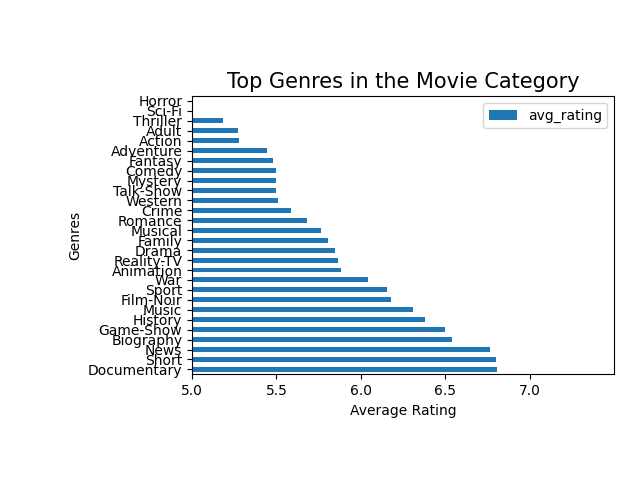

In [88]:
pddf=df3.select("genres", "avg_rating").limit(1000).toPandas()
pddf.plot(kind="barh", x="genres")
plt.title("Top Genres in the Movie Category", size=15)
plt.ylabel("Genres", size=10)
plt.xlabel("Average Rating", size=10)
plt.xticks(np.arange(5,7.5,0.5))
plt.xlim([5,7.5])
plt.subplots_adjust(wspace=0.2, hspace=0.2, left=0.3, bottom=0.22, right=0.96, top=0.8)
%matplot plt

## PART 3 - Analyzing Job Categories

## Total Unique Job Categories

**What is the total number of unique job categories?**

In [28]:
category_split = movie_actors.withColumn('category',explode(split('category',",")))
category_split.select("tconst", "category").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------------+
|   tconst|       category|
+---------+---------------+
|tt0000001|           self|
|tt0000001|       director|
|tt0000001|cinematographer|
|tt0000002|       director|
|tt0000002|       composer|
+---------+---------------+
only showing top 5 rows

In [29]:
unique_catergory = movie_actors.select(countDistinct("category"))
unique_catergory.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|count(DISTINCT category)|
+------------------------+
|12                      |
+------------------------+

**What are the unique job categories available?**

In [30]:
category_split.select("category").distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|           category|
+-------------------+
|            actress|
|           producer|
|production_designer|
|             writer|
|              actor|
|    cinematographer|
|      archive_sound|
|    archive_footage|
|               self|
|             editor|
|           composer|
|           director|
+-------------------+

## Top Job Categories

Now let's find the top job categories in this dataset by rolling up categories.

### Counts of Titles / Job Category

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [31]:
category_split.groupBy("category").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------+
|           category|  count|
+-------------------+-------+
|            actress|6325097|
|           producer|2197866|
|production_designer| 285924|
|             writer|4811596|
|              actor|8493701|
|    cinematographer|1300404|
|      archive_sound|   2143|
|    archive_footage| 209035|
|               self|6153089|
|             editor|1197669|
|           composer|1313187|
|           director|4179106|
+-------------------+-------+

### Bar Chart of Top Job Categories

With this data available, let us now build a barchart of the top 5 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [32]:
category_count= category_split.groupBy("category").count().sort(col("count").desc())
category_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------+
|           category|  count|
+-------------------+-------+
|              actor|8493701|
|            actress|6325097|
|               self|6153089|
|             writer|4811596|
|           director|4179106|
|           producer|2197866|
|           composer|1313187|
|    cinematographer|1300404|
|             editor|1197669|
|production_designer| 285924|
|    archive_footage| 209035|
|      archive_sound|   2143|
+-------------------+-------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

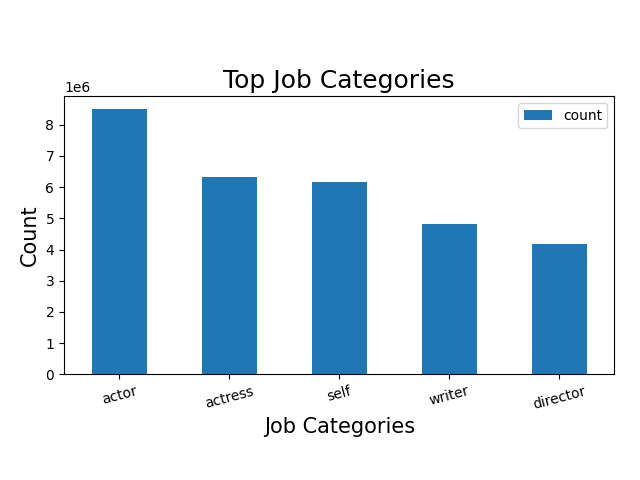

In [90]:
pddf1=category_count.select("category","count").limit(5).toPandas()
pddf1.plot(kind="bar", x="category")
plt.title("Top Job Categories", size=18)
plt.ylabel("Count", size=15)
plt.xlabel("Job Categories", size=15)
plt.subplots_adjust(wspace=0.6, hspace=0.6, left=0.1, bottom=0.22, right=0.96, top=0.8)
plt.xticks(rotation = 15)
%matplot plt

# PART 4 - Answer to the following questions:

## 1) Find all the "movies" featuring "Johnny Depp" and "Helena Bonham Carter".

First join actors, genres, and movie actors on each other

In [34]:
#Join actors and movie actors with "nconst" to create a new table actors_movieactors
actors_movieactors = actors.join(movie_actors, on = ["nconst"], how = "inner").select("nconst","primaryName","tconst")
actors_movieactors.show(10)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----------------+----------+
|   nconst|     primaryName|    tconst|
+---------+----------------+----------+
|nm0000059|Laurence Olivier| tt0848353|
|nm0000059|Laurence Olivier| tt0899312|
|nm0000059|Laurence Olivier| tt0968286|
|nm0000059|Laurence Olivier|tt10045564|
|nm0000059|Laurence Olivier| tt1014940|
|nm0000059|Laurence Olivier| tt1708767|
|nm0000059|Laurence Olivier| tt1710853|
|nm0000059|Laurence Olivier| tt1710854|
|nm0000059|Laurence Olivier| tt1916990|
|nm0000059|Laurence Olivier| tt2144487|
+---------+----------------+----------+
only showing top 10 rows

In [35]:
#Join actors_movieactors and genres with "tconst" to create a new table allthreetables
allthreetables = actors_movieactors.join(genres, on = ["tconst"], how = "inner")\
    .select("titleType","primaryTitle","primaryName","tconst","startYear")
allthreetables.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+-------------------+---------+---------+
|titleType|        primaryTitle|        primaryName|   tconst|startYear|
+---------+--------------------+-------------------+---------+---------+
|    short|     The X-Ray Fiend|          Tom Green|tt0000172|     1897|
|    short|     The X-Ray Fiend|       Laura Bayley|tt0000172|     1897|
|    short|     The X-Ray Fiend|George Albert Smith|tt0000172|     1897|
|    short|A Sea Cave Near L...|     Robert W. Paul|tt0000175|     1896|
|    short|A Sea Cave Near L...|        Henry Short|tt0000175|     1896|
|    short|        The Deserter|     Robert W. Paul|tt0000188|     1898|
|    short|The Sign of the C...|     Georges Méliès|tt0000242|     1899|
|    short|    Monnaie de lapin|          Alice Guy|tt0000254|     1899|
|    short|La fée aux choux,...|          Alice Guy|tt0000302|     1900|
|    short|   Spanish Bullfight|      Louis Lumière|tt0000337|     1900|
|    short|             A táncz|       Lidia Balogh

In [36]:
movie1= allthreetables.select("primaryTitle", "primaryName")\
    .filter((allthreetables.titleType == "movie") & (allthreetables.primaryName =="Johnny Depp"))
movie1.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------------------+-----------+
|primaryTitle                                              |primaryName|
+----------------------------------------------------------+-----------+
|If I Should Fall from Grace: The Shane MacGowan Story     |Johnny Depp|
|Arizona Dream                                             |Johnny Depp|
|Sleepy Hollow                                             |Johnny Depp|
|The Ninth Gate                                            |Johnny Depp|
|Edward Scissorhands                                       |Johnny Depp|
|Once Upon a Time in Mexico                                |Johnny Depp|
|Dead Man                                                  |Johnny Depp|
|The Source: The Story of the Beats and the Beat Generation|Johnny Depp|
|What's Eating Gilbert Grape                               |Johnny Depp|
|A Nightmare on Elm Street                                 |Johnny Depp|
|Donnie Brasco                                     

In [37]:
movie2= allthreetables.select("primaryTitle", "primaryName")\
    .filter((allthreetables.titleType == "movie") & (allthreetables.primaryName =="Helena Bonham Carter"))
movie2.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------+--------------------+
|primaryTitle                                  |primaryName         |
+----------------------------------------------+--------------------+
|Getting It Right                              |Helena Bonham Carter|
|Portraits chinois                             |Helena Bonham Carter|
|The Wings of the Dove                         |Helena Bonham Carter|
|Novocaine                                     |Helena Bonham Carter|
|The Heart of Me                               |Helena Bonham Carter|
|The Petticoat Expeditions                     |Helena Bonham Carter|
|Where Angels Fear to Tread                    |Helena Bonham Carter|
|Women Talking Dirty                           |Helena Bonham Carter|
|Mary Shelley's Frankenstein                   |Helena Bonham Carter|
|Conversations with Other Women                |Helena Bonham Carter|
|Planet of the Apes                            |Helena Bonham Carter|
|Margaret's Museum  

In [38]:
movie3 = movie1.join(movie2, on = ["primaryTitle"], how = "inner").select("primaryTitle")
movie3.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------+
|primaryTitle                                  |
+----------------------------------------------+
|Sweeney Todd: The Demon Barber of Fleet Street|
|Charlie and the Chocolate Factory             |
|Corpse Bride                                  |
|Dark Shadows                                  |
|Alice in Wonderland                           |
|Alice Through the Looking Glass               |
+----------------------------------------------+

## 2) Find all the "movies" featuring "Brad Pitt" after 2010.

In [39]:
movie4= allthreetables.select("primaryTitle", "startYear", "primaryName")\
    .filter((allthreetables.titleType == "movie") & (allthreetables.primaryName =="Brad Pitt"))
movie4.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+-----------+
|        primaryTitle|startYear|primaryName|
+--------------------+---------+-----------+
|              Snatch|     2000|  Brad Pitt|
|    Mr. & Mrs. Smith|     2005|  Brad Pitt|
|A River Runs Thro...|     1992|  Brad Pitt|
|                Troy|     2004|  Brad Pitt|
|Running with Scis...|     2006|  Brad Pitt|
|   Across the Tracks|     1990|  Brad Pitt|
|  Peace Like a River|       \N|  Brad Pitt|
|The Curious Case ...|     2008|  Brad Pitt|
|      Ocean's Eleven|     2001|  Brad Pitt|
|       Cutting Class|     1989|  Brad Pitt|
|               Babel|     2006|  Brad Pitt|
|The Dark Side of ...|     1988|  Brad Pitt|
|          12 Monkeys|     1995|  Brad Pitt|
|      Ocean's Twelve|     2004|  Brad Pitt|
|      A Mighty Heart|     2007|  Brad Pitt|
|               Se7en|     1995|  Brad Pitt|
|           The Favor|     1994|  Brad Pitt|
|     The Book of Joe|       \N|  Brad Pitt|
|          Fight Club|     1999|  Brad Pitt|
|    The T

In [51]:
nll = '\\N'
movie5= movie4.select("primaryTitle", "startYear")\
     .filter((movie4.startYear != nll) & (movie4.startYear >"2010"))\
     .sort(col("startYear").desc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
movie5.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------+---------+
|primaryTitle                     |startYear|
+---------------------------------+---------+
|Babylon                          |2021     |
|Irresistible                     |2020     |
|Kajillionaire                    |2020     |
|The King                         |2019     |
|Once Upon a Time ... in Hollywood|2019     |
|Ad Astra                         |2019     |
|Vice                             |2018     |
|War Machine                      |2017     |
|Voyage of Time: Life's Journey   |2016     |
|Allied                           |2016     |
|The Big Short                    |2015     |
|By the Sea                       |2015     |
|Hitting the Apex                 |2015     |
|Fury                             |2014     |
|World War Z                      |2013     |
|12 Years a Slave                 |2013     |
|Kick-Ass 2                       |2013     |
|Killing Them Softly              |2012     |
|The Tree of Life                 

## 3) What is the number of "movies" "acted" by "Zendaya" per year?

In [44]:
nll = '\\N'
movie6 = allthreetables.select("startYear") \
    .filter((allthreetables.startYear !=nll) & (allthreetables.titleType == "movie") & (allthreetables.primaryName == "Zendaya"))

movie6.groupBy("startYear").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|startYear|count|
+---------+-----+
|     2020|    1|
|     2018|    2|
|     2017|    1|
+---------+-----+

## 4) What are the "movies" by average rating greater than "9.7" and released in "2019"?

In [45]:
#Join allthreetables and movie ratings with "tconst" to create a new table allfourtables
allfourtables = allthreetables.join(movie_ratings, on = ["tconst"], how = "inner")\
    .select("titleType","primaryTitle","primaryName","tconst","startYear","averageRating")
allfourtables.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+-------------------+---------+---------+-------------+
|titleType|        primaryTitle|        primaryName|   tconst|startYear|averageRating|
+---------+--------------------+-------------------+---------+---------+-------------+
|    short|     The X-Ray Fiend|          Tom Green|tt0000172|     1897|          6.0|
|    short|     The X-Ray Fiend|       Laura Bayley|tt0000172|     1897|          6.0|
|    short|     The X-Ray Fiend|George Albert Smith|tt0000172|     1897|          6.0|
|    short|A Sea Cave Near L...|     Robert W. Paul|tt0000175|     1896|          4.9|
|    short|A Sea Cave Near L...|        Henry Short|tt0000175|     1896|          4.9|
|    short|The Sign of the C...|     Georges Méliès|tt0000242|     1899|          6.3|
|    short|La fée aux choux,...|          Alice Guy|tt0000302|     1900|          5.2|
|    short|   Spanish Bullfight|      Louis Lumière|tt0000337|     1900|          5.1|
|    short|             A táncz|       Lidi

In [46]:
movie7 = allfourtables.select("primaryTitle","averageRating") \
    .filter((allfourtables.titleType =="movie") & (allfourtables.startYear =='2019'))\
    .withColumn("averageRating", col("averageRating").cast("float"))
movie7.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------+
|       primaryTitle|averageRating|
+-------------------+-------------+
|Alita: Battle Angel|          7.4|
|Alita: Battle Angel|          7.4|
|Alita: Battle Angel|          7.4|
|Alita: Battle Angel|          7.4|
|Alita: Battle Angel|          7.4|
|Alita: Battle Angel|          7.4|
|Alita: Battle Angel|          7.4|
|Alita: Battle Angel|          7.4|
|Alita: Battle Angel|          7.4|
|Alita: Battle Angel|          7.4|
|        Devil Fetus|          6.2|
|        Devil Fetus|          6.2|
|        Devil Fetus|          6.2|
|        Devil Fetus|          6.2|
|        Devil Fetus|          6.2|
|        Devil Fetus|          6.2|
|        Devil Fetus|          6.2|
|        Devil Fetus|          6.2|
|        Devil Fetus|          6.2|
|        Devil Fetus|          6.2|
+-------------------+-------------+
only showing top 20 rows

In [53]:
movie8 = movie7.select("primaryTitle","averageRating")\
    .filter(movie7.averageRating >"9.7")\
    .sort(movie7.averageRating.desc()).distinct()
movie8.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------+-------------+
|primaryTitle                            |averageRating|
+----------------------------------------+-------------+
|A Medicine for the Mind                 |10.0         |
|A Grunt's Life                          |10.0         |
|Bu Can Var Oldugu Sürece                |10.0         |
|Kirket                                  |10.0         |
|The Butcher Baronet                     |10.0         |
|Our Scripted Life                       |10.0         |
|L'Enfant Terrible                       |10.0         |
|Love in Kilnerry                        |10.0         |
|The Cardinal                            |9.9          |
|Superhombre                             |9.9          |
|Puritan: All of Life to The Glory of God|9.9          |
|Kamen Rider Zi-O: Over Quartzer         |9.8          |
|Randhawa                                |9.8          |
|Square One                              |9.8          |
|Gini Helida Kathe             

## Extra Credit - Analysis of your choice

Try and analyze some interesting dimension to this data. You should specify the question in your Project2_Analysis.ipynb. 

You must join at least two datasets.


What year is the movie "12 Years a Slave " from?

In [54]:
allfourtables.select("startYear") \
    .filter(allfourtables.primaryTitle == "12 Years a Slave") \
    .sort(allfourtables.startYear.desc()).distinct()\
    .show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|startYear|
+---------+
|     2015|
|     2013|
+---------+

How many movies that Brad Pitt acted between 2005 and 2010?

In [57]:
allfourtables.select("startYear") \
  .filter((allfourtables.titleType == "movie") & (allfourtables.startYear >= "2005") & (allfourtables.startYear <= "2010") & (allfourtables.primaryName == "Brad Pitt"))\
    .sort(allfourtables.startYear.desc())\
    .count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12

Show the list of those movies with start year and average rating.

In [58]:
allfourtables.select("primaryTitle","startYear","averageRating") \
    .filter((allfourtables.titleType == "movie") & (allfourtables.startYear >= "2005") & (allfourtables.startYear <= "2010") & (allfourtables.primaryName == "Brad Pitt"))\
    .sort(allfourtables.startYear.desc(), allfourtables.averageRating.desc()).distinct()\
    .show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------------------+---------+-------------+
|primaryTitle                                              |startYear|averageRating|
+----------------------------------------------------------+---------+-------------+
|The Big Uneasy                                            |2010     |7.4          |
|Megamind                                                  |2010     |7.2          |
|Bad Boy Kummer                                            |2010     |6.5          |
|Inglourious Basterds                                      |2009     |8.3          |
|The Curious Case of Benjamin Button                       |2008     |7.8          |
|Burn After Reading                                        |2008     |7.0          |
|The Assassination of Jesse James by the Coward Robert Ford|2007     |7.5          |
|Ocean's Thirteen                                          |2007     |6.9          |
|A Mighty Heart                                            |2007 